# MODEL SELECTION AND EVALUATION: Part 1

In [1]:
import src.constants as cn
import src.util as util

import collections
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import seaborn as sns
from typing import Optional, List

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Lecture 3: Statistical Methods (Nicoleta & Joe) - May 1
Real-world story about challenges/lessons learned to motivate the rest of the discussion (Nicoleta)
Generalizability
Transferability
Definitions
Model distribution (Nicoleta)
Comparison to simpler methods (joe)
Digits recognition by linear regression
Conversion from deep learning to simpler methods
Types of problems in empirical modeling
Cross-validation & data splitting (joe)
More on balancing data. Choice of training vs. test data. (SMOT? synthetic minority ? technique)
Want uncorrelated data
Feature engineering
Less used in deep learning for image data but can be helpful
How to structure data
Reproducibility
Evaluation (metrics, etc. – based on experimental design)

# Outline

1. An anecdote about data curation
1. The MNIST digit data
    1. Full data
    2. Data selection with ``makeDigitData``
3. An easy problem - classifying "3" vs "7"
   1. Modeling workflow and modeling parameters
   2. model construction
   3. prediction
   4. accuracy
4. A harder problem - classifying "1" vs "8"
   1. ``learnDigits``
   2. Repeated results
   3. What can be varied
6. Metrics for assessing quality of a model. Motivation & use cases.
   1. Accuracy for binary, "single shot" classificaiton
   2. Metrics for information retrieval: precision, recall
   3. Multiple classification
7. The confusion matrix
   1. Definition and example
   2. Deriving other metrics from the confusion matrix: accuracy, precision, recall
   3. Diagnostics from the confusion metric
8. Evaluating model quality
    1. Metrics
    2. Do multiple trainings
9. Approaches to improving model quality. Running example using digits and confusion matrix.
   1. More data
   2. Data augmentation
   3. Longer training
   4. More layers
   5. More units in layers
   6. More sophisticated architecture

# Helpers

## plotConfusionMatrix

2024-04-09 16:19:56.316376: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-09 16:19:56.316391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-09 16:19:56.316396: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-09 16:19:56.316417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-09 16:19:56.316434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


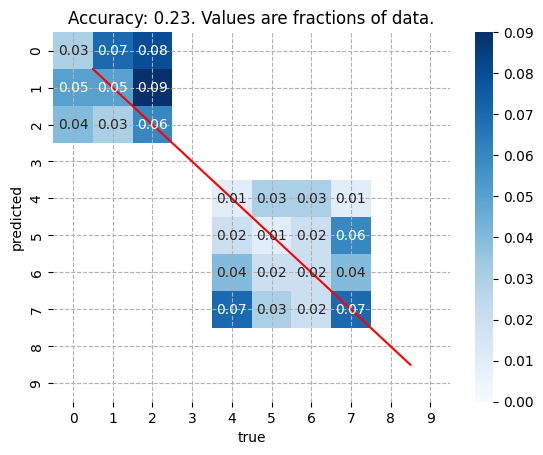

In [2]:
def plotConfusionMatrix(y_true:np.ndarray[int], y_pred:np.ndarray[int]):
    """
    Plots the confusion matrix for the classifications. Values are fraction of data.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    NUM_DIGIT = 10
    labels = set(y_true)
    num_label = NUM_DIGIT
    data_len = len(y_true)
    mat = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_label)
    frc_mat = np.round(mat/data_len, 2)
    mask_mat = np.repeat(True, num_label*num_label)
    mask_mat = np.reshape(mask_mat, (num_label, num_label))
    for yt in range(num_label):
        for yp in range(num_label):
            if not np.isclose(frc_mat[yp, yt], 0):
                mask_mat[yp, yt] = False
    #
    _ = sns.heatmap(np.transpose(frc_mat), cmap="Blues", annot=True,
                    annot_kws={'fontsize': 10}, 
                    mask=np.transpose(mask_mat),
                 vmin=0)
    accuracy = np.round(balanced_accuracy_score(y_true, y_pred), 2)
    plt.grid(linestyle="--")
    plt.ylabel("predicted")
    plt.xlabel("true")
    plt.plot(range(1, num_label), range(1, num_label), c="red")
    plt.title("Accuracy: {accuracy}. Values are fractions of data.".format(accuracy = accuracy))
    plt.show()

# Tests
def mkydata(num_label=8, size=100):
    labels = list(range(num_label))
    if num_label < 4:
        raise ValueError("num_label > 3")
    missing_label = labels[3]
    y1 = np.random.randint(0, missing_label, size//2)
    y2 = np.random.randint(missing_label+1, num_label, size//2)
    return np.concatenate([y1, y2])
#
size = 100
y_true = mkydata()
y_pred = mkydata()
plotConfusionMatrix(y_true, y_pred)

## makeDigitData

In [3]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    base_path = os.path.join(cn.DATA_MNIST_SMALL, datatype)
    ddirs = os.listdir(base_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_ddir = os.path.join(base_path, ddir)
        ffiles = os.listdir(this_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    y_arr = y_arr.astype(int)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(cn.TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

OK!


## displayImage

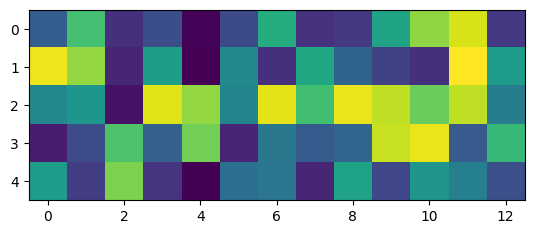

In [4]:
def displayImage(flattened_arr:np.ndarray, nrow=28, ncol=28):
    arr = np.reshape(flattened_arr, (nrow, ncol))
    img = Image.fromarray(arr)
    plt.imshow(img)

# Tests
nrow = 5
ncol = 13
arr = np.uint8(np.random.randint(0, 255, nrow*ncol))
displayImage(arr, nrow=nrow, ncol=ncol)

## learnDigits

***Preparing the data. This can take 30 secs for so.
***Making in-memory test and training data.
***Constructing the model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step


/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


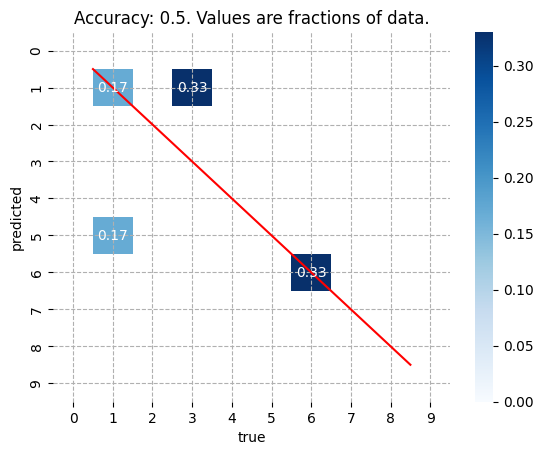

***Constructing the model.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


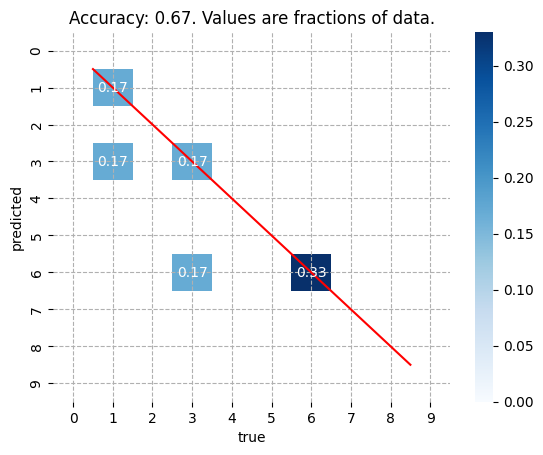

***Preparing the data. This can take 30 secs for so.
OK!


In [5]:
global X_training, y_training, X_testing, y_testing
LearnerInfo = collections.namedtuple("LearnerInfo",
      "model, X_training, y_training, X_testing, y_testing, history"
                                    )
def learnDigits(
    training_count:Optional[int]=None,
    digits:List[int]=range(10),
    hidden1_size:int=8,
    hidden2_size:int=16,
    num_epoch:int=5,
    training_verbose:int=0,
    is_confusion_matrix=True,
    is_model_summary=True,
):
    """
    1. Creates the data for the model from the full MNIST dataset.
    2. Constructs a sequential model with specified sizes of hidden layers
    3. Does prediction for the test set (20% the size of the training data)
    4. Displays accuracy and confusion matrix.

    Args:
        training_count: int (number of training images for each class)
            if None, use existing data.
        digits: list-int (digits/classes considered)
        hidden1_size: int (number of units in the first hidden layer)
        hidden2_size: int (number of units in the second hidden layer)
        num_epoc: int (number of epochs of training)
        verbose: int (verbosity for training)
    Returns:
        LearnerInfo
    """
    global X_training, y_training, X_testing, y_testing
    def makeDirs(error_msg=None):
        print("***Preparing the data. This can take 30 secs for so.")
        if training_count is None:
            if error_msg is None:
                error_msg = "Must specify training count to acquire new data."
            raise ValueError(error_msg)
        sub_dirs = [str(n) for n in digits]
        util.makeDigitDirs(train_count=training_count, sub_dirs=sub_dirs)
    #
    # Create the input data
    is_new_data = False
    if training_count is not None:
        makeDirs()
        is_new_data = True
    # Construct training and test data
    if (not "X_testing" in globals()) or is_new_data:
        print("***Making in-memory test and training data.")
        X_training, y_training = makeDigitData(cn.TRAINING)
        X_testing, y_testing = makeDigitData(cn.TESTING)
        is_new_data = True
    digit_diff = set(y_training).symmetric_difference(digits)
    if len(digit_diff) > 0:
        makeDirs(error_msg="Changed digits but didn't specify training_count.")
        X_training, y_training = makeDigitData(cn.TRAINING)
        X_testing, y_testing = makeDigitData(cn.TESTING)
    # Construct the model
    print("***Constructing the model.")
    max_class = max(y_training) + 1
    model = keras.Sequential(
        [
            keras.Input(shape=(X_training.shape[-1],)),
            layers.Dense(hidden1_size, activation="relu"),
            layers.Dense(hidden2_size, activation="relu"),
            layers.Dense(max_class, activation="softmax"),
        ]
    )
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    if is_model_summary:
        model.summary()
    categorical_y_training = to_categorical(y_training)
    # Train the model
    print("***Training the model.")
    history = model.fit(X_training, categorical_y_training, epochs=num_epoch,
                        batch_size=64,
                        verbose=training_verbose)
    
    y_pred = model.predict(X_testing).argmax(axis=1)
    # Evaluate the result
    if is_confusion_matrix:
        plotConfusionMatrix(y_testing, y_pred)
    return LearnerInfo(
        X_training=X_training, 
        y_training=y_training,
        model=model,
        X_testing=X_testing,
        y_testing=y_testing,
        history=history
    )

# Tests
try:
    learner_info = learnDigits(training_count=10, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Use previous data
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Changed digits
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6, 7], training_verbose=0)
    assert(False)
except Exception as e:
    pass
#
print("OK!")

In [6]:
learner_info.X_testing[0:1, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  91, 236, 212,  89,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 214, 172,  26,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0, 239, 147,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 240, 129,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [7]:
learner_info.model.predict(learner_info.X_testing[0:1, :]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([6])

In [8]:
set(learner_info.y_testing)

{1, 3, 6}

In [9]:
np.shape(learner_info.X_testing[0:2, :])

(2, 784)

In [10]:
np.shape(learner_info.X_testing)

(6, 784)

# Data Curation Anecdote

Task: Build a learner that identifies if an image is a *plane* or a *bird*.

<img src="https://pngimg.com/uploads/birds/birds_PNG49.png" alt="drawing" width="200"/>
<img src="https://i.etsystatic.com/18604024/r/il/d40c9f/4484408200/il_1588xN.4484408200_rfpk.jpg" alt="drawing" width="200"/>
<img src="https://pngimg.com/uploads/plane/plane_PNG101208.png" alt="drawing" width="200"/>

**Larry Bird**
<img src="https://cdn.nba.com/manage/2018/10/larry-bird.jpg" alt="drawing" width="300"/>

We don't want pictures of Larry Bird in our training data!

**Data curation is essential.**

# MNIST Digit Data

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="drawing" width="400"/>

About 6,000 ``png` files for training each digit and 1,000 ``png`` files for testing.

Data selection process.

# A Simple Classification Problem: 3 vs. 7

Let's start with "3" and "7" since this is likely an easier task.

The first step is to figure out the inputs and outputs for what we want to learn. We will be classifying images as either a "3" or a "7". So, there will be two numeric outputs that will indicate the probability of each digit.

The inputs will be the pixels in the ``png``. These are $28 \times 28 = 768$. So there will be 768 input units.

![image](https://www.mathworks.com/discovery/neural-network/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_copy.adapt.full.medium.svg/1710244830270.svg)

3, 7 gives good accuracy w/500.

In [11]:
learnDigits(
    training_count=500,
    digits=[1, 8], training_verbose=1,
    is_confusion_matrix=False,
)

***Preparing the data. This can take 30 secs for so.
***Making in-memory test and training data.
***Constructing the model.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 8)              │         6,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,577 (25.69 KB)

 Trainable params: 6,577 (25.69 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3811 - loss: 9.7112 
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4867 - loss: 8.2540
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4980 - loss: 8.0913
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5209 - loss: 7.7230
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4741 - loss: 8.4713
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


LearnerInfo(model=<Sequential name=sequential_2, built=True>, X_training=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), y_training=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

# What is a model and how do we evaluate it?

1. Data
1. Inputs to learner and outputs from learner
1. Structure of the learner

The model depends on the task.
1. Classification.
    1. How many classes?
    2. Use case
       1. "Single shot" - Does this picture include my daughter?
       2. Retrieval -- Find all photos of my daughter
1. Regression - Predict numeric values
   1. How old is this brain?
   2. How deep is the snow?

Model evaluation depends on the task
1. Single shot - accuracy
2. Retrieval
   1. Precision - what fraction of the pictures actually contain my daughter
   2. Recall - what fraction of the pictures with my daughter are recalled

Metrics
1. Accuracy
2. Precision
3. Recall

In [12]:
The confusion matrix and derivation of metrics from it.

SyntaxError: invalid syntax (3972360736.py, line 1)

Factors affecting model quality
1. Quality and amount of data
2. Size of the model (in number of parameters)
3. Number of training epocs
4. Complexity of the problem

The foregoing also impact the training time

## Construct full data of features (X) and labels (y)

## Model then curate

1. Create a small dataset (1000 images) with 3 digits.
2. Evaluate quality

# 